In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# remove arnings (optional)
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
# our dataset is in cocoformat, we will need pypcoco tools
!pip install pycocotools
from pycocotools.coco import COCO

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from albumentations.pytorch import ToTensorV2

In [5]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [6]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [7]:
dataset_path = "animal species.v2-2024-03-04-6-24pm-kishore-and-team-v2.coco/"

In [8]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{0: {'id': 0,
  'name': 'Panthera-crocodillia-Loxodonta-S',
  'supercategory': 'none'},
 1: {'id': 1,
  'name': 'Accipitridae',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 2: {'id': 2,
  'name': 'Canidae',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 3: {'id': 3,
  'name': 'Cervidae',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 4: {'id': 4,
  'name': 'Crocodilia',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 5: {'id': 5,
  'name': 'Equidae',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 6: {'id': 6,
  'name': 'Lepidoptera',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 7: {'id': 7,
  'name': 'Loxodonta',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 8: {'id': 8,
  'name': 'Ursidae',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'},
 9: {'id': 9,
  'name': 'panthera',
  'supercategory': 'Panthera-crocodillia-Loxodonta-S'}}

In [9]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Panthera-crocodillia-Loxodonta-S',
 'Accipitridae',
 'Canidae',
 'Cervidae',
 'Crocodilia',
 'Equidae',
 'Lepidoptera',
 'Loxodonta',
 'Ursidae',
 'panthera']

In [10]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


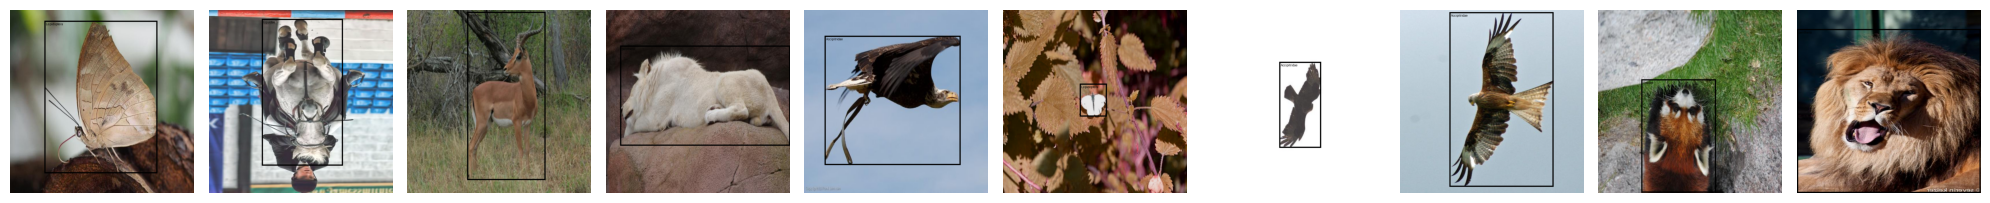

In [11]:
num_samples_to_display = 10  # Set the number of samples to display

fig, axes = plt.subplots(1, num_samples_to_display, figsize=(20, 10))

for i in range(num_samples_to_display):
    sample = train_dataset[i]  # Access each sample from the dataset
    img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)  # Convert image to tensor

    # Plot each image with bounding boxes
    axes[i].imshow(draw_bounding_boxes(
        img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
    ).permute(1, 2, 0))
    axes[i].axis('off')  # Turn off axis labels
    
plt.tight_layout()
plt.show()

In [12]:
len(train_dataset)

1074

In [13]:
# lets load the faster rcnn model
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [16]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [17]:
device = torch.device("cuda")
model = model.to(device)


In [18]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [19]:
import sys

In [20]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [21]:
num_epochs = 15

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:28<00:00,  9.29it/s]


Epoch 0, lr: 0.010000, loss: 0.839187, loss_classifier: 0.424588, loss_box: 0.355400, loss_rpn_box: 0.033089, loss_object: 0.026110


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.90it/s]


Epoch 1, lr: 0.010000, loss: 0.736722, loss_classifier: 0.356269, loss_box: 0.334861, loss_rpn_box: 0.028744, loss_object: 0.016848


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:27<00:00,  9.90it/s]


Epoch 2, lr: 0.010000, loss: 0.703917, loss_classifier: 0.338438, loss_box: 0.323178, loss_rpn_box: 0.026985, loss_object: 0.015316


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.07it/s]


Epoch 3, lr: 0.010000, loss: 0.739026, loss_classifier: 0.350054, loss_box: 0.350547, loss_rpn_box: 0.025443, loss_object: 0.012982


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.03it/s]


Epoch 4, lr: 0.010000, loss: 0.680617, loss_classifier: 0.315925, loss_box: 0.326480, loss_rpn_box: 0.025552, loss_object: 0.012659


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.14it/s]


Epoch 5, lr: 0.010000, loss: 0.671086, loss_classifier: 0.300709, loss_box: 0.336080, loss_rpn_box: 0.023639, loss_object: 0.010658


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.13it/s]


Epoch 6, lr: 0.010000, loss: 0.671880, loss_classifier: 0.298701, loss_box: 0.338555, loss_rpn_box: 0.023724, loss_object: 0.010900


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.18it/s]


Epoch 7, lr: 0.010000, loss: 0.685826, loss_classifier: 0.312275, loss_box: 0.339441, loss_rpn_box: 0.023153, loss_object: 0.010957


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.26it/s]


Epoch 8, lr: 0.010000, loss: 0.662157, loss_classifier: 0.288041, loss_box: 0.341703, loss_rpn_box: 0.022658, loss_object: 0.009755


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.13it/s]


Epoch 9, lr: 0.010000, loss: 0.657615, loss_classifier: 0.284636, loss_box: 0.341760, loss_rpn_box: 0.021973, loss_object: 0.009245


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.26it/s]


Epoch 10, lr: 0.010000, loss: 0.692197, loss_classifier: 0.315346, loss_box: 0.345356, loss_rpn_box: 0.022793, loss_object: 0.008702


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.18it/s]


Epoch 11, lr: 0.010000, loss: 0.600592, loss_classifier: 0.238055, loss_box: 0.332848, loss_rpn_box: 0.021237, loss_object: 0.008451


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.23it/s]


Epoch 12, lr: 0.010000, loss: 0.575347, loss_classifier: 0.240008, loss_box: 0.305323, loss_rpn_box: 0.021534, loss_object: 0.008482


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:26<00:00, 10.25it/s]


Epoch 13, lr: 0.010000, loss: 0.612149, loss_classifier: 0.256666, loss_box: 0.324089, loss_rpn_box: 0.021584, loss_object: 0.009810


100%|█████████████████████████████████████████████████████████████████████████████████| 269/269 [00:25<00:00, 10.39it/s]

Epoch 14, lr: 0.010000, loss: 0.571048, loss_classifier: 0.230061, loss_box: 0.313189, loss_rpn_box: 0.020547, loss_object: 0.007250


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


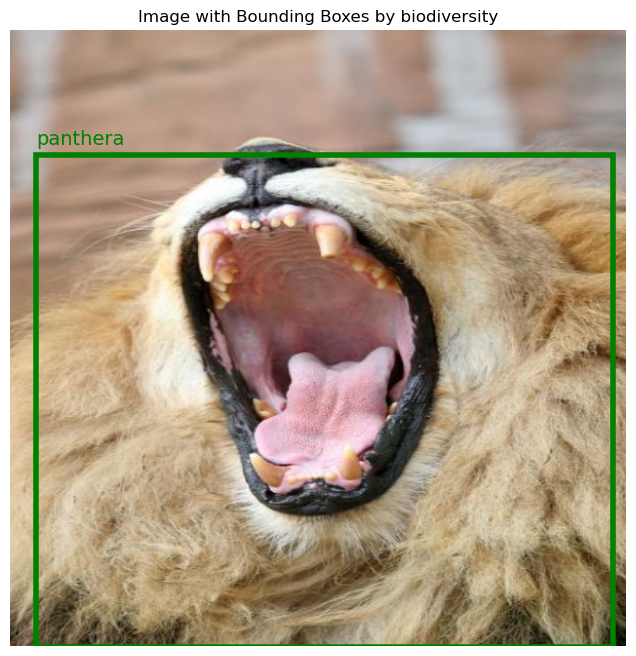

Number of boxes and labels mismatch for image 1


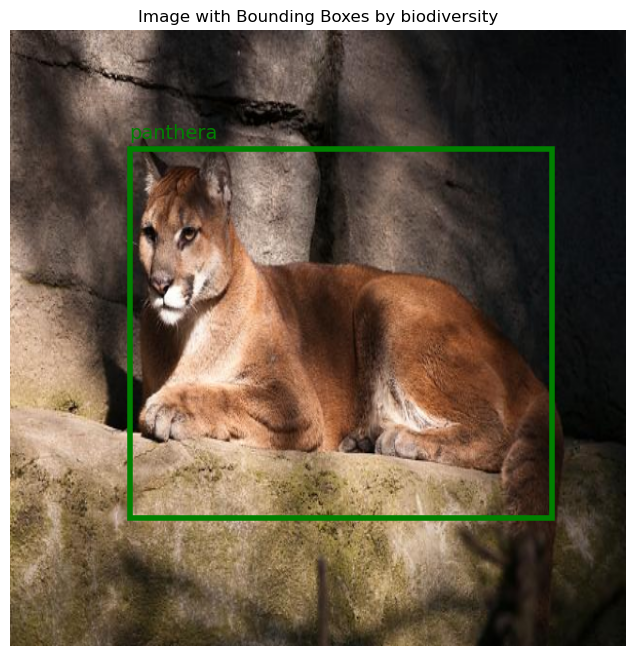

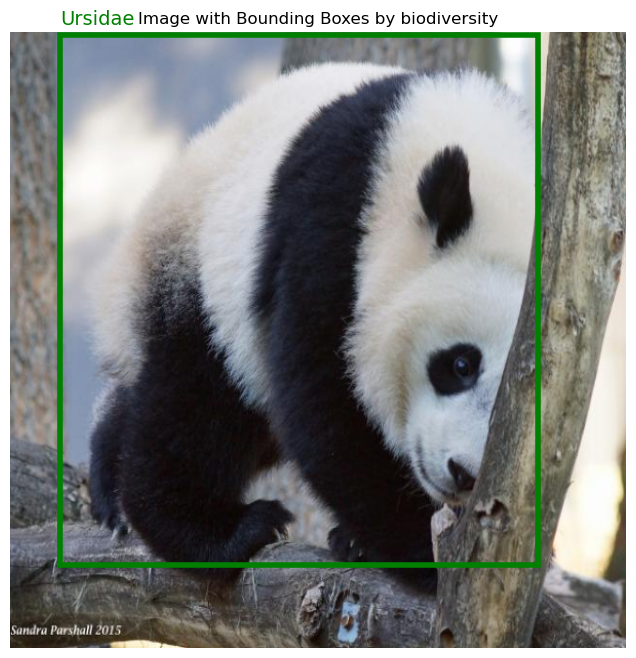

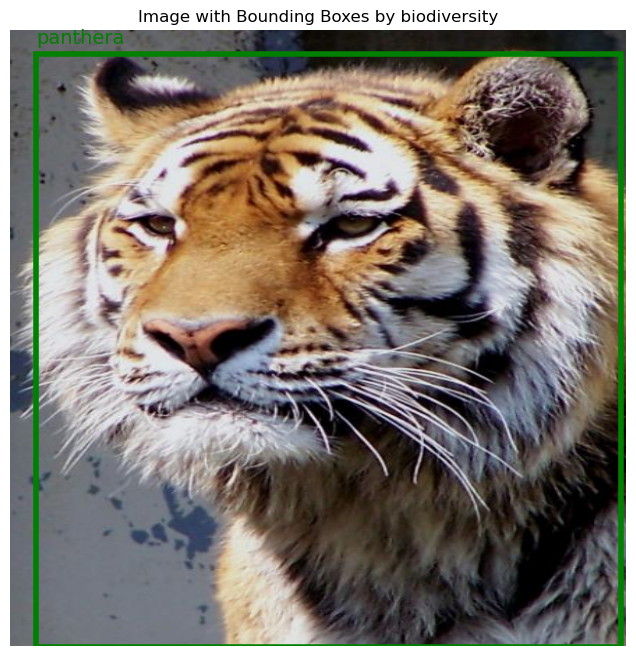

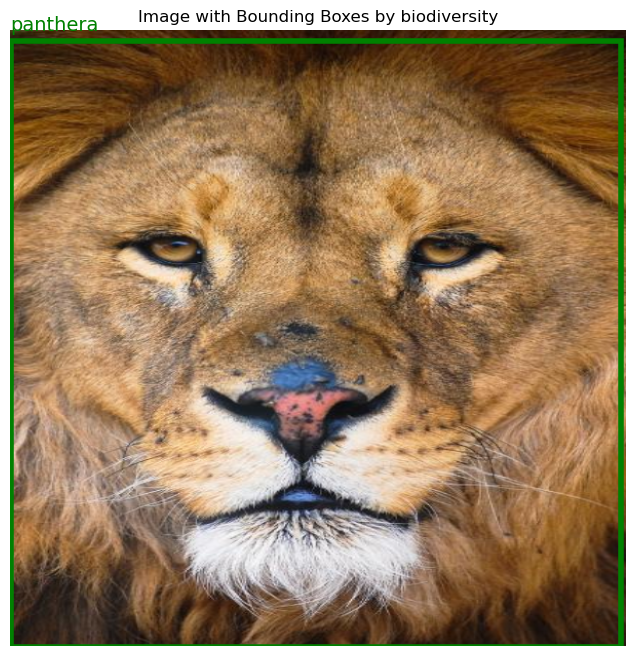

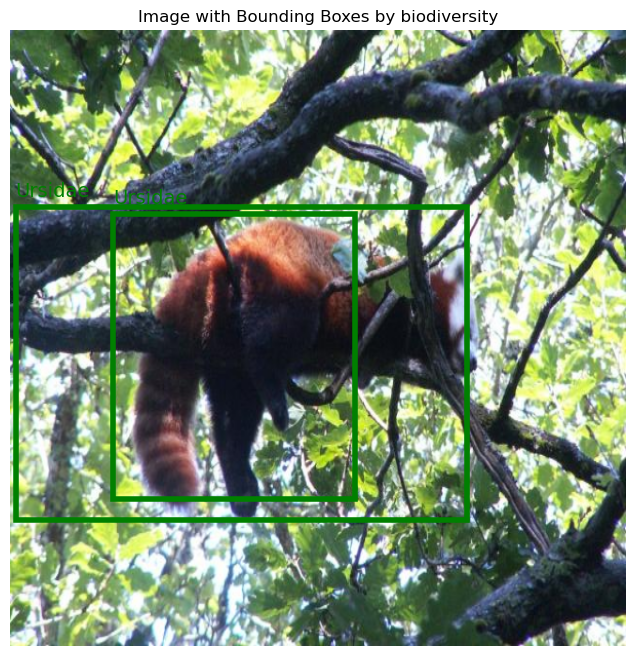

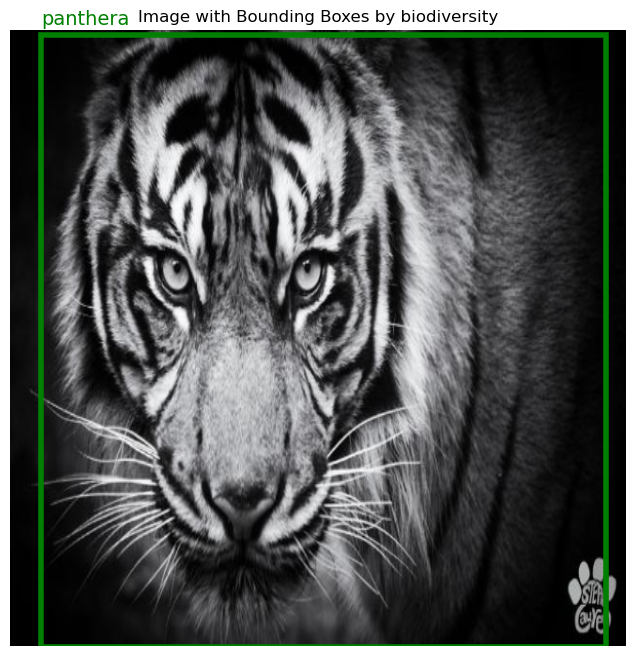

In [22]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))
model.eval()
torch.cuda.empty_cache()

num_images_to_display = 10
count_displayed = 0

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]

    if count_displayed < num_images_to_display and len(pred['labels']) > 0:
        boxes_to_plot = pred['boxes'][pred['scores'] > 0.3]
        labels_to_plot = [classes[i] for i in pred['labels'][pred['scores'] > 0.2].tolist()]

        if len(labels_to_plot) != len(boxes_to_plot):
            print(f"Number of boxes and labels mismatch for image {i}")
            labels_to_plot = labels_to_plot[:len(boxes_to_plot)]

        img_int = torch.tensor(img * 255, dtype=torch.uint8)
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        # Change color of bounding boxes and increase font size
        for bbox, label in zip(boxes_to_plot, labels_to_plot):
            xmin, ymin, xmax, ymax = map(int, bbox.tolist())
            color = 'red' if label == 'fish' else 'green'  # Change color based on label
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=4))
            ax.text(xmin, ymin - 10, label, fontsize=14, color=color)  # Increase font size

        ax.imshow(img_int.permute(1, 2, 0))
        ax.set_title('Image with Bounding Boxes by biodiversity')
        ax.axis('off')
        plt.show()

        count_displayed += 1

    if count_displayed >= num_images_to_display:
        break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


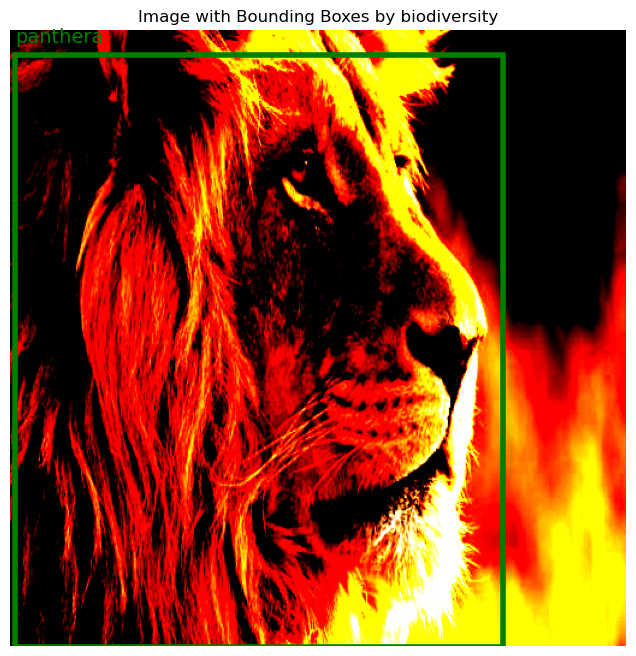

In [23]:
test_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(False))
model.eval()
torch.cuda.empty_cache()

# Define a function to process image and display output
def process_image(image_path):
    # Load the input image
    image = np.array(Image.open(image_path))
    
    # Define transformations
    transform = A.Compose([
        A.Resize(512, 512),  # Resize the image
        A.Normalize(),  # Normalize the image
        ToTensorV2()  # Convert to tensor
    ])
    
    # Apply transformations
    transformed = transform(image=image)
    image = transformed['image']
    image = image.unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(image)
        pred = prediction[0]
    
    # Process prediction and display output
    if len(pred['labels']) > 0:
        boxes_to_plot = pred['boxes'][pred['scores'] > 0.3]
        labels_to_plot = [classes[i] for i in pred['labels'][pred['scores'] > 0.2].tolist()]
        
        # Display output
        img_int = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
        img_int *= 2# Scale back to 0-255 range
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        for bbox, label in zip(boxes_to_plot, labels_to_plot):
            xmin, ymin, xmax, ymax = map(int, bbox.tolist())
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=color, linewidth=4))
            ax.text(xmin, ymin - 10, label, fontsize=14, color=color)
        ax.imshow(img_int)
        ax.set_title('Image with Bounding Boxes by biodiversity')
        ax.axis('off')
        plt.show()
    else:
        print("No objects detected in the input image.")

# Example usage:
image_path = "animal species.v2-2024-03-04-6-24pm-kishore-and-team-v2.coco/train/03b9630d0ba5749d_jpg.rf.af782508a246a43b5873d60ca9889f91.jpg"

process_image(image_path)
